# Use case 2: retrieving the corrections

## Notebook setup

In [45]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [46]:
import sys

sys.path.append("../..")

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [48]:
import s1etad
from s1etad import Sentinel1Etad, ECorrectionType

## Open the dataset

In [49]:
filename = (
    "data/"
    "S1A_IW_ETA__AXDV_20230806T211729_20230806T211757_049760_05FBCB_9DD6.SAFE"
)

In [50]:
eta = Sentinel1Etad(filename)

In [51]:
swath = eta["IW1"]

In [52]:
burst = swath[1]

In [53]:
burst

Sentinel1EtadBurst("/IW1/Burst0001")  0x75fbd39d60b0
Swaths ID: IW1
Burst index: 1
Shape: (108, 402)
Sampling start:
  x: 0.0
  y: 0.0
  units: s
Sampling:
  x: 8.131672451354599e-07
  y: 0.02932551319648094
  units: s

## Get corrections

The Sentinel1EtadBurst class allows to access the netcdf product to retrieve the corrections burst by burst.

The recommended way to retrieve a correction is:

```python
s1etad.Sentinel1EtadBurst.get_correction(name, set_auto_mask=False,
                                         transpose=True, meter=False)
```

Available correction types are:

In [54]:
s1etad.ECorrectionType.__members__

mappingproxy({'TROPOSPHERIC': <ECorrectionType.TROPOSPHERIC: 'tropospheric'>,
              'TROPOSPHERIC_GRADIENT': <ECorrectionType.TROPOSPHERIC_GRADIENT: 'tropospheric_gradient'>,
              'IONOSPHERIC': <ECorrectionType.IONOSPHERIC: 'ionospheric'>,
              'GEODETIC': <ECorrectionType.GEODETIC: 'geodetic'>,
              'OTL': <ECorrectionType.OTL: 'otl'>,
              'BISTATIC': <ECorrectionType.BISTATIC: 'bistatic'>,
              'DOPPLER': <ECorrectionType.DOPPLER: 'doppler'>,
              'FMRATE': <ECorrectionType.FMRATE: 'fmrate'>,
              'SUM': <ECorrectionType.SUM: 'sum'>})

**Example**:

In [55]:
# correction = burst.get_correction('ionospheric')
#
# or equivalently
correction = burst.get_correction(
    s1etad.ECorrectionType.IONOSPHERIC, meter=True
)
correction.keys()

dict_keys(['x', 'unit', 'name'])

Text(0.5, 1.0, 'ionospheric correction (swath IW1 burst 1)')

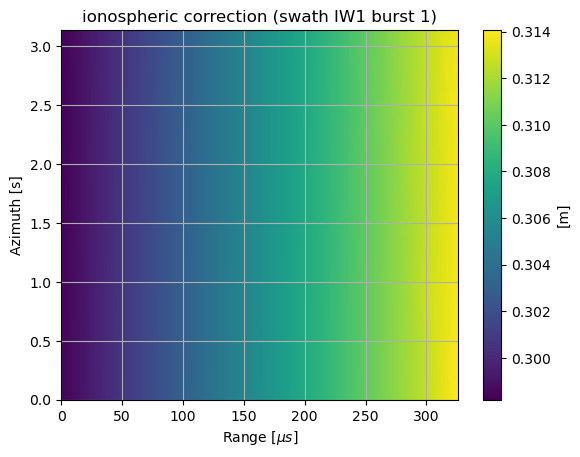

In [56]:
az, rg = burst.get_burst_grid()
extent = [rg[0] * 1e6, rg[-1] * 1e6, az[0], az[-1]]

plt.figure()
plt.imshow(correction["x"], extent=extent, aspect="auto")
plt.xlabel(r"Range [$\mu s$]")
plt.ylabel("Azimuth [s]")
plt.grid()
plt.colorbar().set_label(f"[{correction['unit']}]")
plt.title(
    f"{correction['name']} correction (swath {burst.swath_id} "
    f"burst {burst.burst_index})"
)

## Retrieving merged corrections

The `Sentinel1Etad` and `Sentinel1EtadSwath` classes provides methods to retrieve a specific correction for multiple bursts merged together for easy representation purposes.

**NOTE**: the current implementation uses a very simple algorithm that iterates over selected bursts and stitches correction data together. In overlapping regions new data simply overwrite the old ones.  This is an easy algorithm and perfectly correct for atmospheric and geodetic correction. It is, instead, sub-optimal for system corrections (bi-static, Doppler, FM Rate) which have different values in overlapping regions.

### First select the bursts

In [57]:
import dateutil.parser

first_time = dateutil.parser.parse("2023-08-06T21:17:34.000000")
last_time = dateutil.parser.parse("2023-08-06T21:17:53.000000")

product_name = (
    "S1A_IW_SLC__1SDV_20230806T211729_20230806T211757_049760_05FBCB_BC56.SAFE"
)

# query the catalogue for a subset of the swaths
df = eta.query_burst(
    first_time=first_time, last_time=last_time, product_name=product_name
)

# df = df[df.bIndex != 13]   # exclude burst n. 13 (IW1))
#                            # to test extended selection capabilities
# df = df[df.bIndex != 17]   # exclude burst n. 17 (IW2))
#                            # to test extended selection capabilities
# df = df[df.bIndex != 15]   # exclude burst n. 17 (IW3))
#                            # to test extended selection capabilities

In [58]:
df

,bIndex,pIndex,sIndex,productID,swathID,azimuthTimeMin,azimuthTimeMax
2,7,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:34.721407480,2023-08-06 21:17:37.888562906
12,8,1,2,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW2,2023-08-06 21:17:35.659823903,2023-08-06 21:17:38.826979328
21,9,1,3,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW3,2023-08-06 21:17:36.627565838,2023-08-06 21:17:39.794721263
3,10,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:37.478005721,2023-08-06 21:17:40.645161146
13,11,1,2,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW2,2023-08-06 21:17:38.416422143,2023-08-06 21:17:41.612903082
22,12,1,3,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW3,2023-08-06 21:17:39.384164079,2023-08-06 21:17:42.580645017
4,13,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:40.234603961,2023-08-06 21:17:43.401759387
14,14,1,2,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW2,2023-08-06 21:17:41.173020384,2023-08-06 21:17:44.369501322
23,15,1,3,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW3,2023-08-06 21:17:42.140762319,2023-08-06 21:17:45.337243258
5,16,1,1,S1A_IW_SLC__1SDV_20230806T211729_20230806T2117...,IW1,2023-08-06 21:17:42.991202202,2023-08-06 21:17:46.158357627


#### Common variables

In [59]:
from scipy import constants

dy = eta.grid_spacing["y"]
dx = eta.grid_sampling["x"] * constants.c / 2
nswaths = len(df.swathID.unique())
vg = eta.grid_spacing["y"] / eta.grid_sampling["y"]
vmin = 2.5
vmax = 3.5
to_km = 1.0 / 1000

### Iterate on swath to get de-bursted data (selected burst merged together)

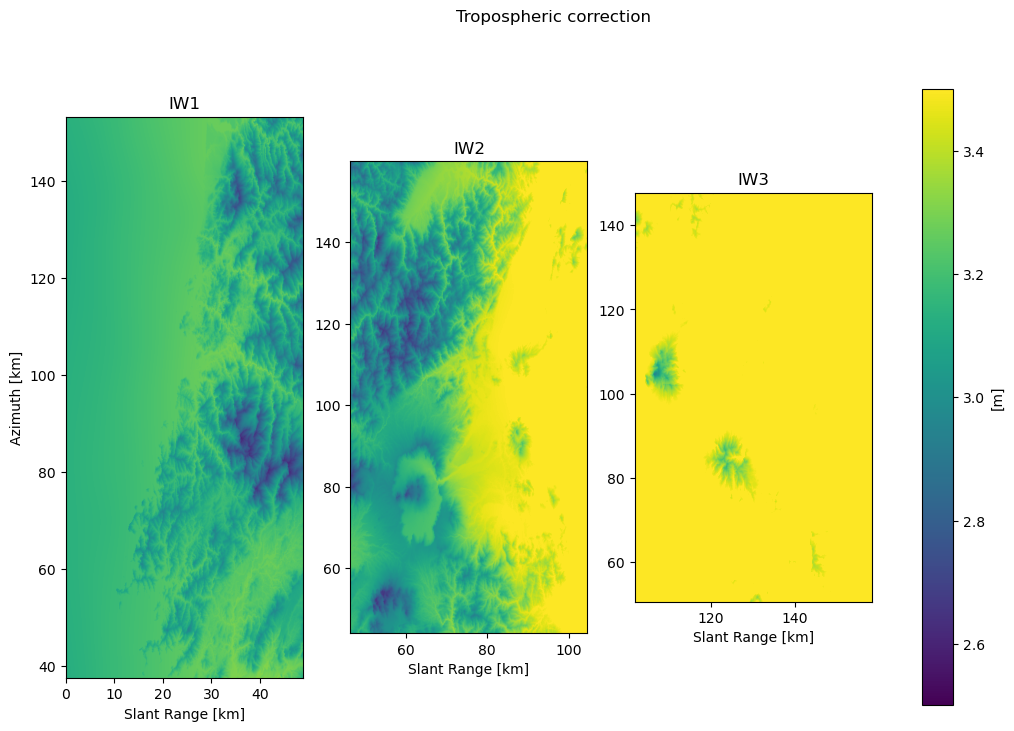

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=nswaths, figsize=[13, 8])
for idx, swath in enumerate(eta.iter_swaths(df)):
    merged_correction = swath.merge_correction(
        ECorrectionType.TROPOSPHERIC, selection=df, meter=True
    )
    merged_correction_data = merged_correction["x"]

    ysize, xsize = merged_correction_data.shape
    x0 = merged_correction["first_slant_range_time"] * constants.c / 2  # [m]
    y0 = merged_correction["first_azimuth_time"] * vg  # [m]
    x_axis = (x0 + np.arange(xsize) * dx) * to_km
    y_axis = (y0 + np.arange(ysize) * dy) * to_km

    extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]
    im = ax[idx].imshow(
        merged_correction_data,
        origin="lower",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        aspect="equal",
    )
    ax[idx].set_title(swath.swath_id)
    ax[idx].set_xlabel("Slant Range [km]")

ax[0].set_ylabel("Azimuth [km]")

name = merged_correction["name"]
unit = merged_correction["unit"]

fig.suptitle(f"{name.title()} correction")
fig.colorbar(im, ax=ax[:].tolist(), label=f"[{unit}]")

### Get merged swaths

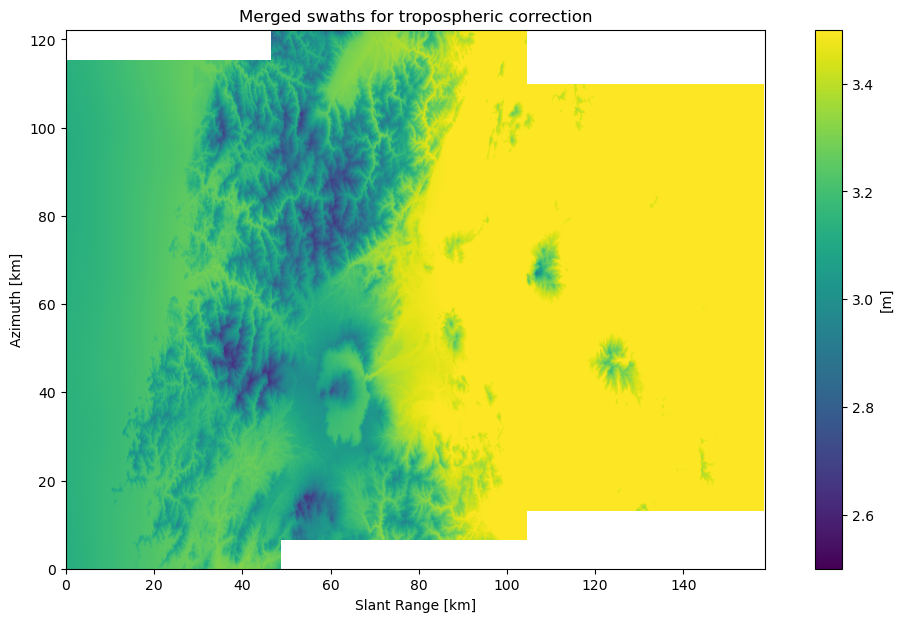

In [61]:
fig, ax = plt.subplots(figsize=[13, 7])
merged_correction = eta.merge_correction(
    ECorrectionType.TROPOSPHERIC, selection=df, meter=True
)
merged_correction_data = merged_correction["x"]

ysize, xsize = merged_correction_data.shape
x_axis = np.arange(xsize) * dx * to_km
y_axis = np.arange(ysize) * dy * to_km

extent = [x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]]
im = ax.imshow(
    merged_correction_data,
    origin="lower",
    extent=extent,
    vmin=vmin,
    vmax=vmax,
    aspect="equal",
)

ax.set_xlabel("Slant Range [km]")
ax.set_ylabel("Azimuth [km]")

name = merged_correction["name"]
unit = merged_correction["unit"]

ax.set_title(f"Merged swaths for {name} correction")
fig.colorbar(im, ax=ax, label=f"[{unit}]")